In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import copy
import datetime as dt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
df_train = pd.read_csv("Life_train.csv")
df_test = pd.read_csv("Life_test.csv")

In [3]:
print(df_train.size, df_test.size)

49780 8341


In [4]:
df_train.isna().sum()

Year                                 0
Life expectancy                      0
Adult Mortality                      0
infant deaths                        0
Alcohol                            167
percentage expenditure               0
Hepatitis B                        480
Measles                              0
 BMI                                28
under-five deaths                    0
Polio                               18
Total expenditure                  196
Diphtheria                          18
 HIV/AIDS                            0
GDP                                386
Population                         554
 thinness  1-19 years               28
 thinness 5-9 years                 28
Income composition of resources    146
Schooling                          146
dtype: int64

In [5]:
df_test.isna().sum()

Year                                0
Adult Mortality                     0
infant deaths                       0
Alcohol                            26
percentage expenditure              0
Hepatitis B                        73
Measles                             0
 BMI                                4
under-five deaths                   0
Polio                               1
Total expenditure                  30
Diphtheria                          1
 HIV/AIDS                           0
GDP                                57
Population                         90
 thinness  1-19 years               4
 thinness 5-9 years                 4
Income composition of resources    14
Schooling                          14
dtype: int64

In [6]:
df_train.fillna(df_train.median(), inplace=True)

In [7]:
df_test.fillna(df_test.median(), inplace=True)

In [8]:
X, Y = df_train.drop("Life expectancy ", axis=1), df_train["Life expectancy "]

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.1)

In [12]:
class Trainer:
    def __init__(self, dataset, net, loss_f, learning_rate=1e-3, epoch_amount=10, batch_size=12,
                 max_batches_per_epoch=None, device='cpu', early_stopping=10, optim=optim.SGD,
                 scheduler=None, permutate=True):
        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []

    def predict(self, X):
        self.best_model.eval()
        with torch.no_grad():
            X = torch.tensor(X, dtype=torch.float32).to(self.device)
            predictions = self.best_model(X)
        return predictions.cpu().numpy()

    def fit(self, X_train, X_test, y_train, y_test):
        net = self.start_model
        net.to(self.device)

        optimizer = self.optim(net.parameters(), lr=self.learning_rate)

        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer, step_size=40, gamma=0.5)

        train_dataset = self.dataset(X_train, y_train)
        val_dataset = self.dataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=self.permutate)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf')
        best_ep = 0

        for epoch in range(self.epoch_amount):
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train_loader:
                if self.max_batches_per_epoch is not None and batch_n >= self.max_batches_per_epoch:
                    break

                optimizer.zero_grad()
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            net.eval()
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val_loader:
                    if self.max_batches_per_epoch is not None and batch_n >= self.max_batches_per_epoch:
                        break
                    batch_X = batch_X.to(self.device)
                    target = target.to(self.device)

                    predicted_values = net(batch_X)
                    loss = self.loss_f(predicted_values, target)

                    mean_loss += float(loss)
                    batch_n += 1

                mean_loss /= batch_n
                self.val_loss.append(mean_loss)
                print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break

            if self.scheduler is not None:
                scheduler.step()
            print()

In [13]:
ReLu = nn.ReLU()


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(19, 50)
        self.fc2 = nn.Linear(50, 250)
        self.fc3 = nn.Linear(250, 250)
        self.fc5 = nn.Linear(250, 50)
        self.fc6 = nn.Linear(50, 1)
        

    def forward(self, x):
        out = self.fc1(x)
        out = ReLu(out)
        out = self.fc2(out)
        out = ReLu(out)
        out = self.fc3(out)
        out = ReLu(out)
        out = self.fc5(out)
        out = ReLu(out)
        out = self.fc6(out)
        out = out.squeeze(-1)
        return out

In [14]:
net = Net()

trainer = Trainer(
    dataset=MyDataset,
    net=net,
    loss_f=nn.MSELoss(),
    learning_rate=1e-3,
    epoch_amount=200,
    batch_size=32,
    optim=optim.SGD,
    early_stopping=50,
    scheduler=optim.lr_scheduler.StepLR,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

trainer.fit(X_train, X_test, y_train.to_numpy(), y_test.to_numpy())

c:\Users\Alex\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\cuda\__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Эпоха: 0 Loss_train: 4622.861364746093, 0:00:00.087019 сек
Loss_val: 3897.32080078125

Эпоха: 1 Loss_train: 3345.1835414341517, 0:00:00.087138 сек
Loss_val: 2975.650604248047

Эпоха: 2 Loss_train: 2550.43173828125, 0:00:00.092711 сек
Loss_val: 2277.868438720703

Эпоха: 3 Loss_train: 1949.8977416992188, 0:00:00.088823 сек
Loss_val: 1749.438491821289

Эпоха: 4 Loss_train: 1496.1526733398437, 0:00:00.087365 сек
Loss_val: 1349.2019348144531

Эпоха: 5 Loss_train: 1153.3496207101005, 0:00:00.088979 сек
Loss_val: 1045.8382949829102

Эпоха: 6 Loss_train: 894.2775765555245, 0:00:00.090968 сек
Loss_val: 815.8149948120117

Эпоха: 7 Loss_train: 698.5428567068917, 0:00:00.082033 сек
Loss_val: 641.335090637207

Эпоха: 8 Loss_train: 550.661376953125, 0:00:00.092093 сек
Loss_val: 508.9382019042969

Эпоха: 9 Loss_train: 438.9761705671038, 0:00:00.089169 сек
Loss_val: 408.4925727844238

Эпоха: 10 Loss_train: 354.59921373639787, 0:00:00.083603 сек
Loss_val: 332.0424499511719

Эпоха: 11 Loss_train: 290.79

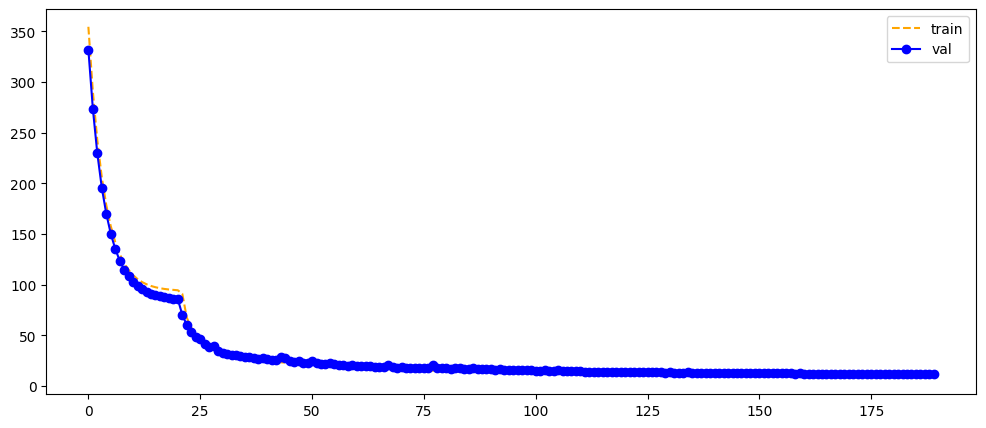

In [15]:
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

plot_loss(trainer.train_loss[10:], trainer.val_loss[10:])

In [20]:
X_test = scaler.transform(df_test)
ans = trainer.predict(X_test)
ans.reshape(-1)
pd.Series(ans.reshape(-1)).to_csv("NN_sub.csv")